<a href="https://colab.research.google.com/github/ashmousaXX/Diabetes-Prediction-using-Machine-Learning/blob/main/Classification_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix)
df = pd.read_csv("/content/diabetes_prediction_dataset.csv")
print("Dataset loaded successfully")
df.head()



Dataset loaded successfully


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


EDA


In [ ]:

# Info about dataset

print(df.info())
print(df.describe())
print("\nMissing Values:\n", df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB
None
                 age  hypertension  heart_disease            bmi  \
count  100000.000000  100000.00000  100000.000000  100000.000000   
mean       41.885856       0.07485       0.039420      27.320767   
std        22.516840       0.26315       0.194593       6.6

#TARGET DISTRIBUTION

Target class counts:
diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64


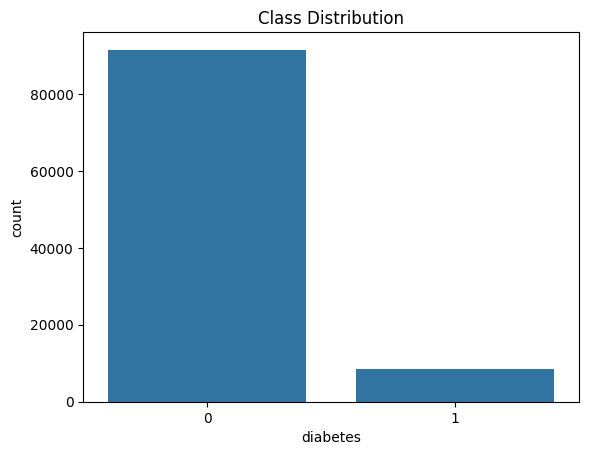

In [ ]:
target_col = 'diabetes'

print("Target class counts:")
print(df[target_col].value_counts(normalize=True))

sns.countplot(x=target_col, data=df)
plt.title('Class Distribution')
plt.show()


#Peprocessing


In [ ]:

dup_count = df.duplicated().sum()
if dup_count > 0:
    df.drop_duplicates(inplace=True)
    print(f"Removed {dup_count} duplicate rows")
else:
    print("No duplicates found")


Removed 3854 duplicate rows



3. Handling Outliers - Detailed Analysis...


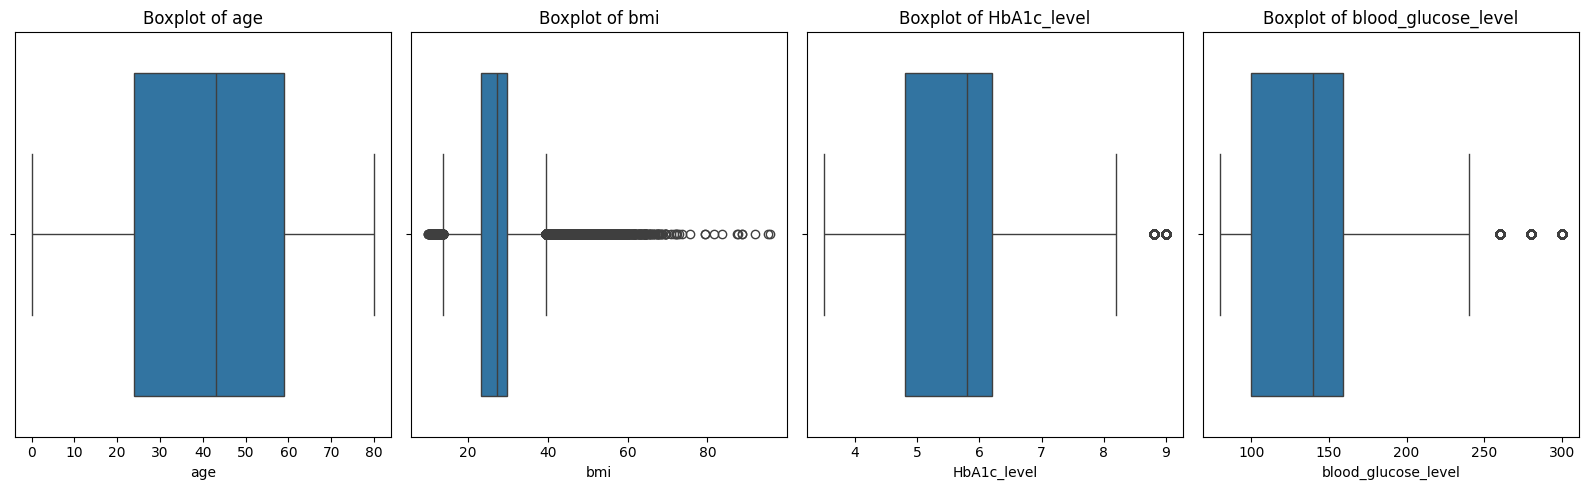


   Outliers Before Treatment:
   age: 0 outliers (0.00%)
   bmi: 5354 outliers (5.57%)
   HbA1c_level: 1312 outliers (1.36%)
   blood_glucose_level: 2031 outliers (2.11%)


In [ ]:
# 5️⃣ OUTLIER VISUALIZATION
print("\n3. Handling Outliers - Detailed Analysis...")

num_cols = ['age','bmi','HbA1c_level','blood_glucose_level']

plt.figure(figsize=(16,5))
for i, col in enumerate(num_cols):
    plt.subplot(1, len(num_cols), i+1)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

print("\n   Outliers Before Treatment:")
for col in num_cols:
    if col != 'diabetes':
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers_before = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outliers_percentage = (outliers_before / len(df)) * 100

        print(f"   {col}: {outliers_before} outliers ({outliers_percentage:.2f}%)")

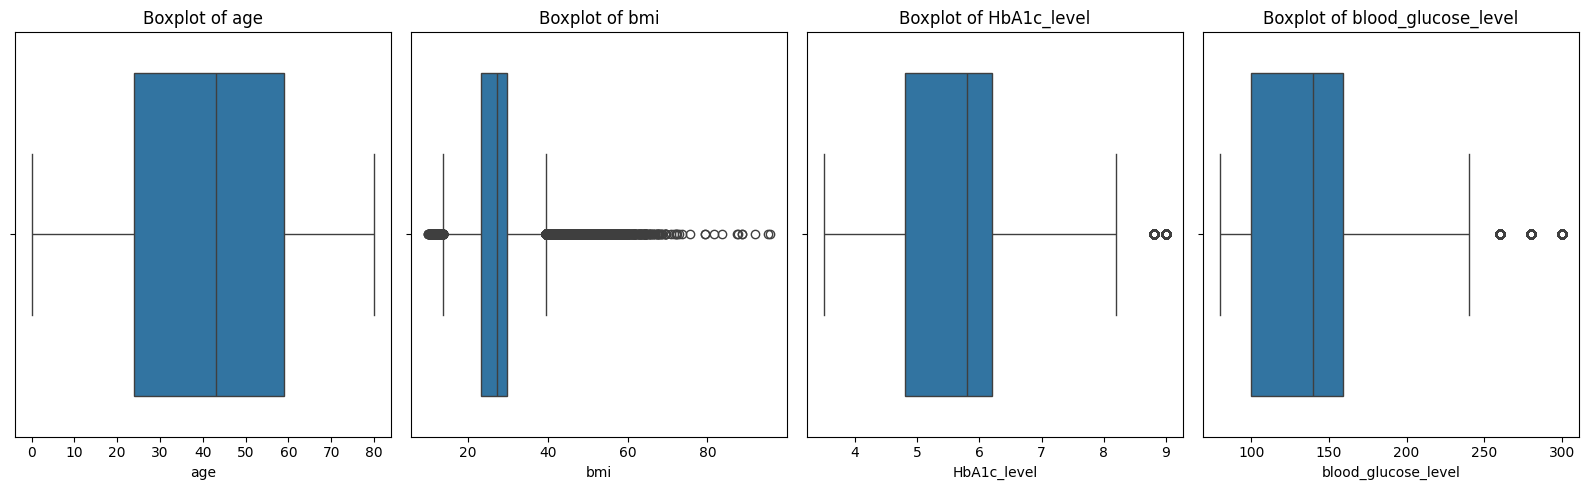


   Outliers After Treatment:
   age: 0 outliers remaining
   bmi: 0 outliers remaining
   HbA1c_level: 0 outliers remaining
   blood_glucose_level: 0 outliers remaining
Outliers treated using IQR capping


In [ ]:
plt.figure(figsize=(16,5))
for i, col in enumerate(num_cols):
    plt.subplot(1, len(num_cols), i+1)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()


for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[col] = np.clip(df[col], lower_bound, upper_bound)
print("\n   Outliers After Treatment:")
for col in num_cols:
    if col != 'diabetes':
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers_after = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        print(f"   {col}: {outliers_after} outliers remaining")
print("Outliers treated using IQR capping")



In [ ]:
#Encoding (one-hot encoding)

df['smoking_history'] = df['smoking_history'].replace('No Info', 'never')
cat_cols = ['gender','smoking_history']
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True ,dtype=int)
df_encoded.head()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Male,gender_Other,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,6.6,140.0,0,0,0,0,0,1,0
1,54.0,0,0,27.32,6.6,80.0,0,0,0,0,0,1,0
2,28.0,0,0,27.32,5.7,158.0,0,1,0,0,0,1,0
3,36.0,0,0,23.45,5.0,155.0,0,0,0,0,0,0,0
4,76.0,1,1,20.14,4.8,155.0,0,1,0,0,0,0,0


In [ ]:
# TRAIN/TEST SPLIT

X = df_encoded.drop(target_col, axis=1)
y = df_encoded[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

print("Train/Test split done!")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train/Test split done!
Train shape: (76916, 12)
Test shape: (19230, 12)


#Logistic Regression


In [ ]:


pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])


In [ ]:
from sklearn.model_selection import cross_val_score

print("=" * 50)
print("LOGISTIC REGRESSION MODEL")
print("=" * 50)

#train model on data
pipeline_lr.fit(X_train, y_train)

#Make prediction
y_pred_log_reg = pipeline_lr.predict(X_test)
y_pred_prob_log_reg = pipeline_lr.predict_proba(X_test)[:, 1]

#Evaluation
accuracy_log = accuracy_score(y_test, y_pred_log_reg)
precision_log = precision_score(y_test, y_pred_log_reg)
recall_log = recall_score(y_test, y_pred_log_reg)
f1_log = f1_score(y_test, y_pred_log_reg)
roc_auc_log = roc_auc_score(y_test, y_pred_prob_log_reg)

print(f"Accuracy: {accuracy_log:.4f}")
print(f"Precision: {precision_log:.4f}")
print(f"Recall: {recall_log:.4f}")
print(f"F1-Score: {f1_log:.4f}")
print(f"ROC-AUC: {roc_auc_log:.4f}")

# Cross-validation
cv_scores = cross_val_score(pipeline_lr, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-Validation ROC-AUC (5-fold): {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

# Feature importance for Logistic Regression
coeff_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': pipeline_lr.named_steps['classifier'].coef_[0],
    'Abs_Coefficient': np.abs(pipeline_lr.named_steps['classifier'].coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\nTop 5 Most Important Features (Logistic Regression):")
print(coeff_df.head())

LOGISTIC REGRESSION MODEL
Accuracy: 0.8808
Precision: 0.4165
Recall: 0.8762
F1-Score: 0.5646
ROC-AUC: 0.9591
Cross-Validation ROC-AUC (5-fold): 0.9611 (+/- 0.0035)

Top 5 Most Important Features (Logistic Regression):
               Feature  Coefficient  Abs_Coefficient
4          HbA1c_level     2.360003         2.360003
5  blood_glucose_level     1.287856         1.287856
0                  age     1.189999         1.189999
3                  bmi     0.727786         0.727786
1         hypertension     0.201521         0.201521


#Random Forest

In [ ]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])


In [ ]:
import time
from sklearn.model_selection import RandomizedSearchCV

print("="*70)
print("OPTIMIZED HYPERPARAMETER TUNING")
print("="*70)

#Hyperparameter
param_dist_rf = {
    'rf__n_estimators': [100, 150],
    'rf__max_depth': [10, 15, 20],
    'rf__min_samples_split': [5, 10],
    'rf__min_samples_leaf': [2, 4],
    'rf__max_features': ['sqrt', 'log2']
}

random_search_rf = RandomizedSearchCV(
    estimator=pipeline_rf,
    param_distributions=param_dist_rf,
    n_iter=8,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
#Fit Randomizedsearch
start_time = time.time()
random_search_rf.fit(X_train, y_train)
end_time = time.time()
print(f"Tuning completed in {end_time - start_time:.1f} seconds")

print("\n" + "="*50)
print("HYPERPARAMETER TUNING RESULTS")
print("="*50)

print("\nBest Hyperparameters:")
print(random_search_rf.best_params_)
print(f"Best CV ROC-AUC: {random_search_rf.best_score_:.4f}")


#PREDICTION
best_rf = random_search_rf.best_estimator_

y_pred_rf = best_rf.predict(X_test)
y_pred_prob_rf = best_rf.predict_proba(X_test)[:,1]

print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_prob_rf):.4f}")


print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

rf_features = best_rf.named_steps['rf'].feature_importances_
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_features
}).sort_values('Importance', ascending=False)

print(rf_importance.head(5))


print("\nTop 5 Most Important Features (Logistic Regression):")
print(rf_importance.head(5))

OPTIMIZED HYPERPARAMETER TUNING
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Tuning completed in 185.6 seconds

HYPERPARAMETER TUNING RESULTS

Best Hyperparameters:
{'rf__n_estimators': 150, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 2, 'rf__max_features': 'log2', 'rf__max_depth': 15}
Best CV ROC-AUC: 0.9734
Accuracy: 0.9258
Precision: 0.5520
Recall: 0.8414
F1-Score: 0.6667
ROC-AUC: 0.9728

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.93      0.96     17534
           1       0.55      0.84      0.67      1696

    accuracy                           0.93     19230
   macro avg       0.77      0.89      0.81     19230
weighted avg       0.95      0.93      0.93     19230

               Feature  Importance
4          HbA1c_level    0.404856
5  blood_glucose_level    0.300578
0                  age    0.167540
3                  bmi    0.072338
1         hypertension    0.026718

Top 5 Most Important

# COMAPER THE MODELS

In [ ]:

metrics_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [accuracy_log, accuracy_score(y_test, y_pred_rf)],
    'Precision': [precision_log, precision_score(y_test, y_pred_rf)],
    'Recall': [recall_log, recall_score(y_test, y_pred_rf)],
    'F1-Score': [f1_log, f1_score(y_test, y_pred_rf)],
    'ROC-AUC': [roc_auc_log, roc_auc_score(y_test, y_pred_prob_rf)]
})

print("="*50)
print("MODEL PERFORMANCE COMPARISON")
print("="*50)
print(metrics_comparison.round(4))

print("\n" + "="*50)
print("BEST MODEL SELECTION")
print("="*50)

best_model_name = "Random Forest" if roc_auc_score(y_test, y_pred_prob_rf) > roc_auc_log else "Logistic Regression"
print(f"Best model based on ROC-AUC: {best_model_name}")

MODEL PERFORMANCE COMPARISON
                 Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC
0  Logistic Regression    0.8808     0.4165  0.8762    0.5646   0.9591
1        Random Forest    0.9258     0.5520  0.8414    0.6667   0.9728

BEST MODEL SELECTION
Best model based on ROC-AUC: Random Forest


#VISULAIZATION


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc


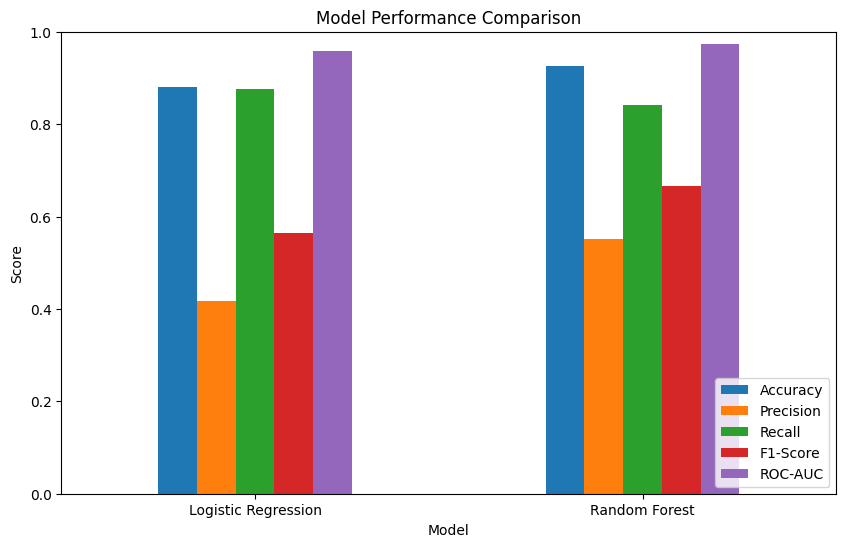

In [ ]:
# ====== 1. Bar Plot for Metrics Comparison ======
metrics_plot = metrics_comparison.set_index('Model')
metrics_plot.plot(kind='bar', figsize=(10,6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()






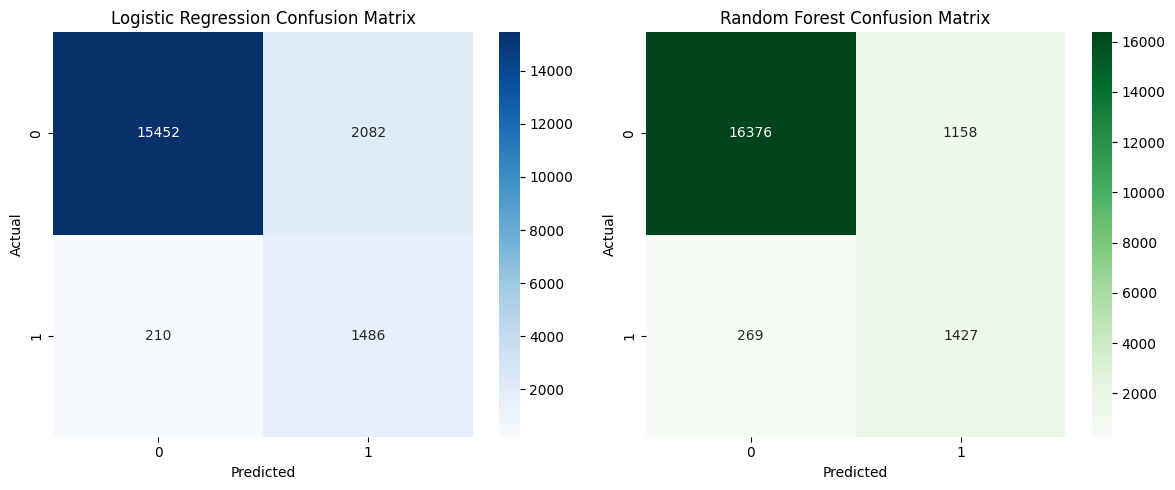

In [ ]:
.# ====== 2. Confusion Matrices ======
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_log_reg)
sns.heatmap(cm_lr, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title("Logistic Regression Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

# Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', ax=axes[1], cmap='Greens')
axes[1].set_title("Random Forest Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


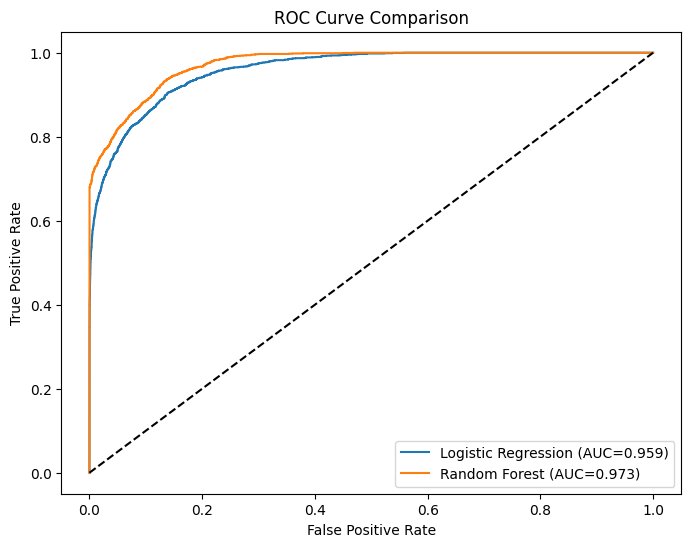

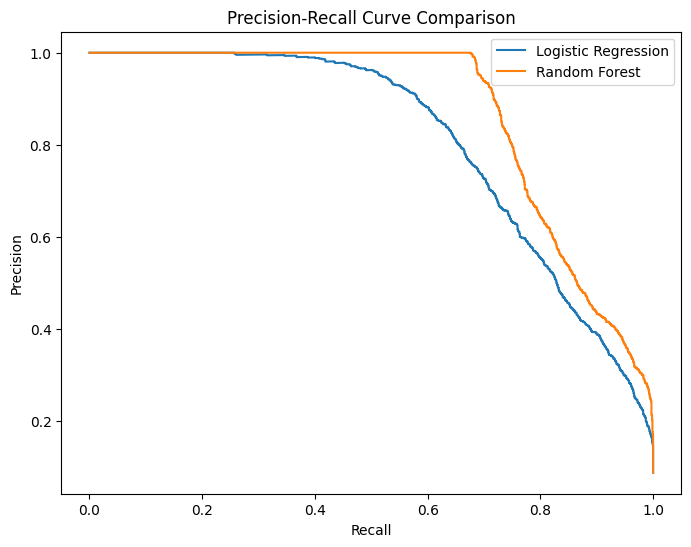

In [ ]:

# ====== 3. ROC Curve ======
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_prob_log_reg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_prob_rf)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={roc_auc_log:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_score(y_test, y_pred_prob_rf):.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

# ====== 4. Precision-Recall Curve ======
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_prob_log_reg)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_prob_rf)

plt.figure(figsize=(8,6))
plt.plot(recall_lr, precision_lr, label='Logistic Regression')
plt.plot(recall_rf, precision_rf, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.show()